## Iris Classification

import all necesarry libraries

In [24]:
import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sk.__version__)
print('matplotlib version:', matplotlib.__version__)

%matplotlib inline

numpy version: 1.12.1
pandas version: 0.20.1
scikit-learn version: 0.18.1
matplotlib version: 2.0.2


Reading iris dataframe

In [13]:
datafolder = 'data/'
filename = 'iris.data.csv'
iris = pd.read_csv(datafolder + filename, sep=',', low_memory=False, encoding = 'ISO-8859-1')
print(iris.shape)
iris.head()

(149, 5)


,5.1,3.5,1.4,0.2,Iris-setosa
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


In the output above can be seen that there are no proper headers, this we have to add them

In [15]:
iris.columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Species']
iris.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Species
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


map species types to numbers to allow us to analyse it

In [19]:
iris['Label'] = iris['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica':2})
iris.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Species,Label
0,4.9,3.0,1.4,0.2,Iris-setosa,0
1,4.7,3.2,1.3,0.2,Iris-setosa,0
2,4.6,3.1,1.5,0.2,Iris-setosa,0
3,5.0,3.6,1.4,0.2,Iris-setosa,0
4,5.4,3.9,1.7,0.4,Iris-setosa,0


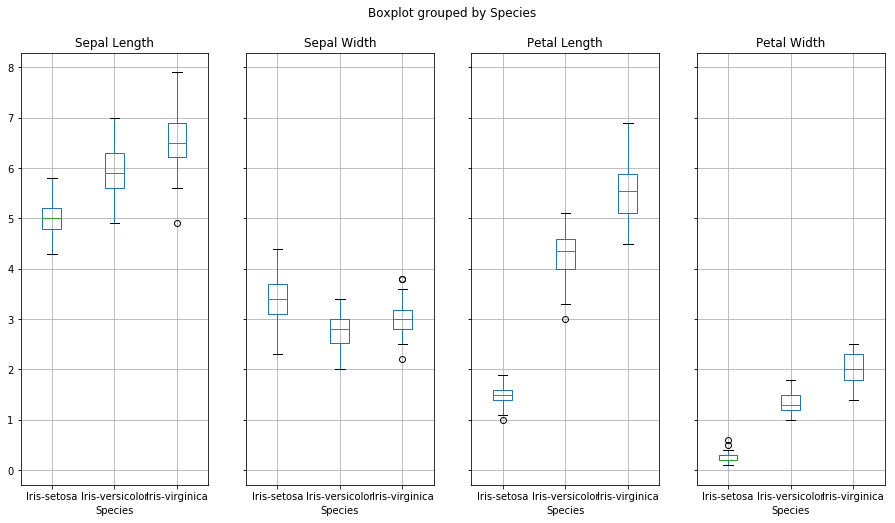

In [26]:
features = tuple(iris.columns[:4].values)
iris.boxplot(column=features, by='Species', figsize=(15,8), layout=(1,4));